In [1]:
import torch
import torchvision
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm


In [2]:

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (required for ViT)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


In [ ]:

# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# weights = ViT_B_16_Weights.IMAGENET1K_V1
# model = vit_b_16(weights=weights)

# model.heads.head = torch.nn.Linear(model.heads.head.in_features, 10)

# model = model.to(device)
# # Set up optimizer, loss, and scheduler
# optimizer = Adam(model.parameters(), lr=1e-4)
# criterion = CrossEntropyLoss()
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# from torch.cuda.amp import GradScaler, autocast

# scaler = GradScaler()

# def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()

#             # Mixed precision forward and backward
#             with autocast():
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)

#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#             running_loss += loss.item()

#         scheduler.step()
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# # Validation Loop
# def validate_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     print(f"Accuracy: {100 * correct / total:.2f}%")

# # Train and Validate
# train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10)
# validate_model(model, test_loader)

In [3]:
from tqdm import tqdm
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.cuda.amp import GradScaler, autocast

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
model.heads.head = torch.nn.Linear(model.heads.head.in_features, 10)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

scaler = GradScaler()

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train
        scheduler.step()

        test_accuracy = validate_model(model, test_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {running_loss/len(train_loader):.4f} "
              f"| Train Accuracy: {train_accuracy:.2f}% | Test Accuracy: {test_accuracy:.2f}% "
              f"| LR: {scheduler.get_last_lr()[0]:.6f}")

def validate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10)

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 229MB/s] 
<ipython-input-3-98b82a4e9068>:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training Epoch 1/10:   0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-3-98b82a4e9068>:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training Epoch 1/10: 100%|██████████| 782/782 [07:44<00:00,  1.68it/s]


Epoch [1/10] | Loss: 0.2075 | Train Accuracy: 93.30% | Test Accuracy: 94.87% | LR: 0.000100


Training Epoch 2/10: 100%|██████████| 782/782 [07:51<00:00,  1.66it/s]


Epoch [2/10] | Loss: 0.1100 | Train Accuracy: 96.34% | Test Accuracy: 95.30% | LR: 0.000100


Training Epoch 3/10: 100%|██████████| 782/782 [07:50<00:00,  1.66it/s]


Epoch [3/10] | Loss: 0.0893 | Train Accuracy: 96.99% | Test Accuracy: 95.54% | LR: 0.000100


Training Epoch 4/10: 100%|██████████| 782/782 [07:51<00:00,  1.66it/s]


Epoch [4/10] | Loss: 0.0810 | Train Accuracy: 97.27% | Test Accuracy: 94.67% | LR: 0.000100


Training Epoch 5/10: 100%|██████████| 782/782 [07:50<00:00,  1.66it/s]


Epoch [5/10] | Loss: 0.0727 | Train Accuracy: 97.52% | Test Accuracy: 95.05% | LR: 0.000010


Training Epoch 6/10: 100%|██████████| 782/782 [07:48<00:00,  1.67it/s]


Epoch [6/10] | Loss: 0.0145 | Train Accuracy: 99.55% | Test Accuracy: 97.17% | LR: 0.000010


Training Epoch 7/10: 100%|██████████| 782/782 [07:46<00:00,  1.68it/s]


Epoch [7/10] | Loss: 0.0047 | Train Accuracy: 99.88% | Test Accuracy: 97.27% | LR: 0.000010


Training Epoch 8/10: 100%|██████████| 782/782 [07:46<00:00,  1.68it/s]


Epoch [8/10] | Loss: 0.0039 | Train Accuracy: 99.90% | Test Accuracy: 97.02% | LR: 0.000010


Training Epoch 9/10: 100%|██████████| 782/782 [07:47<00:00,  1.67it/s]


Epoch [9/10] | Loss: 0.0024 | Train Accuracy: 99.95% | Test Accuracy: 97.38% | LR: 0.000010


Training Epoch 10/10: 100%|██████████| 782/782 [07:47<00:00,  1.67it/s]


Epoch [10/10] | Loss: 0.0028 | Train Accuracy: 99.92% | Test Accuracy: 97.59% | LR: 0.000001


In [4]:
torch.save(model.state_dict(), "vit_cifar10.pth")
print("Model weights saved to 'vit_cifar10.pth'")

Model weights saved to 'vit_cifar10.pth'


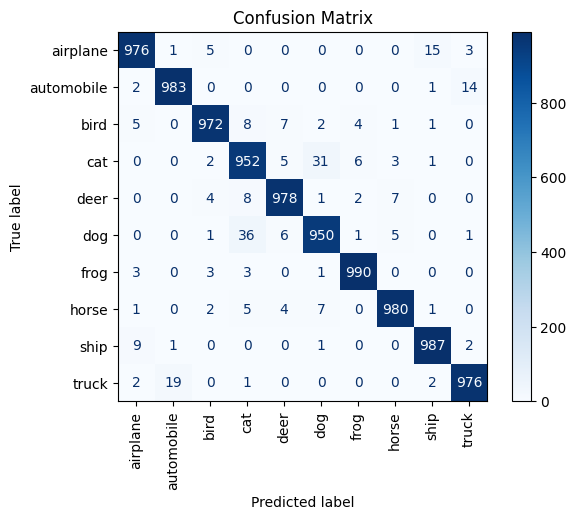

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute Confusion Matrix
def compute_confusion_matrix(model, test_loader):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm

# Display the Confusion Matrix
cm = compute_confusion_matrix(model, test_loader)
classes = train_dataset.classes  # CIFAR-10 class names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

In [8]:
from PIL import Image
import numpy as np

# Load the trained model
model.load_state_dict(torch.load("vit_cifar10.pth"))
model.eval()

# Predict a single image
def predict_single_image(image_path, model, transform):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Open image and apply transformations
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

# Example prediction
image_path = "/kaggle/input/airplane/airplane.jpg"  # Provide a path to your image
predicted_class = predict_single_image(image_path, model, transform)

classes = [
    "airplane", "automobile", "bird", "cat", 
    "deer", "dog", "frog", "horse", "ship", "truck"
]

print(f"Predicted Class: {classes[predicted_class]}")

<ipython-input-8-d65e7e4be501>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vit_cifar10.pth"))


Predicted Class: airplane
